In [58]:
import sympy as sp
import numpy as np
from sympy.physics.vector import dynamicsymbols
from sympy.physics.vector import time_derivative
from sympy.physics.vector import ReferenceFrame
N = ReferenceFrame('N')
import pylab as pl
import control
from EoM import *
from sympy.physics.mechanics import *
from numpy.linalg import matrix_rank, eig
import math
import intelligent_robotics as ir
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import WIP_utils as utils
import modern_robotics as mr


In [27]:
h = 0.8

s = -0.031694468757419

m1 = 2.486 + 0.3
m2 = 1.416
m3 = 1.739
m4 = 16.09

L1 = 0.171
L2 = 0.28
L3 = 0.280
L4 = 0.346

L2c = L2 - 0.045289
L3c = L3 - 0.18878

A = (h-L4-L1)/L2
B = s/L2

theta_2, theta_3 = sp.symbols('theta_2, theta_3')
f1 = sp.Eq(sp.sin(theta_2)+sp.sin(theta_3),float(A))
f2 = sp.Eq(sp.cos(theta_2)+sp.cos(theta_3),float(B))
# f3 = sp.Eq(sp.sin(theta_2)+sp.sin(theta_3),float(E))

sol = sp.solve([f1,f2])
solu = sol[0]

theta_2 = solu[theta_2]
theta_3 = solu[theta_3]
q1 = np.pi/2
q2 = theta_2-q1
q3 = theta_3-q1-q2
q4 = -(q2+q3)

# thetalistd = np.array([q1, q2, q3,q4])
q1, q2, q3, q4

(1.5707963267948966, -0.925805396129726, 2.07467047296167, -1.14886507683195)

In [34]:
def get_deg(h):
    m2 = 1.416
    m3 = 1.739
    m4 = 16.09

    L1 = 0.171
    L2 = 0.28
    L3 = 0.28
    L4 = 0.346

    L2c = L2 - 0.045289
    L3c = L3 - 0.18878

    theta_3, q2 = sp.symbols('theta_3, q2')
    
    A = (h-L1-L4)/L2
    B = m2*L2c + m3*L2+m4*L2
    C = m3*L3c + m4*L3
    
    f1 = sp.Eq(sp.cos(q2)+sp.sin(theta_3),float(A))
    f2 = sp.Eq(-float(B)*sp.sin(q2)+float(C)*sp.cos(theta_3),0)
    sol = sp.solve([f1,f2])
    solu = sol[0]

    q2 = solu[q2]
    theta_3 = solu[theta_3]
    q1 = np.pi/2
    q3 = theta_3-q1-q2
    q4 = -(q2+q3)

    # thetalistd = np.array([q1, q2, q3,q4])
    return q1, q2, q3, q4, h

In [35]:
def get_end_point(q1, q2, q3, q4):
    m1 = 2.486 + 0.3
    m2 = 1.416
    m3 = 1.739
    m4 = 16.09

    L1 = 0.171
    L2 = 0.28
    L3 = 0.28
    L4 = 0.346

    L1c = L1
    L2c = L2 - 0.045289
    L3c = L3 - 0.18878
    L4c = 0.17188

    theta_1 = q1
    theta_2 = q1 + q2
    theta_3 = q1 + q2 + q3
    theta_4 = q1 + q2 + q3 + q4

    x = L1 * sp.cos(theta_1) + L2 * sp.cos(theta_2) + L3 * sp.cos(theta_3) + L4 * sp.cos(theta_4)
    z = L1 * sp.sin(theta_1) + L2 * sp.sin(theta_2) + L3 * sp.sin(theta_3) + L4 * sp.sin(theta_4)

    x_1 = L1c * sp.cos(theta_1)
    x_2 = L1 * sp.cos(theta_1) + L2c * sp.cos(theta_2)
    x_3 = L1 * sp.cos(theta_1) + L2 * sp.cos(theta_2) + L3c*sp.cos(theta_3)
    x_4 = L1 * sp.cos(theta_1) + L2 * sp.cos(theta_2) + L3 * sp.cos(theta_3) + L4c * sp.cos(theta_4)
    x_com = (m1*x_1 + m2*x_2 + m3*x_3+ m4*x_4) / (m1 + m2 + m3 + m4)

    z_1c = L1c * sp.sin(theta_1)
    z_2c = L1 * sp.sin(theta_1) + L2c * sp.sin(theta_2)
    z_3c = L1 * sp.sin(theta_1) + L2 * sp.sin(theta_2) + L3c*sp.sin(theta_3)
    z_4c = L1 * sp.sin(theta_1) + L2 * sp.sin(theta_2) + L3 * sp.sin(theta_3) + L4c * sp.sin(theta_4)

    z_com = (m1*z_1c + m2*z_2c + m3*z_3c + m4*z_4c) / (m1 + m2 + m3 + m4)
    theta_P = np.arctan(float(x_com)/float(z_com))
    return x,z, theta_P


In [36]:
q1, q2, q3, q4, h = get_deg(0.8)

In [37]:
x,z, theta_P = get_end_point(q1, q2, q3, q4)
x,z, theta_P

(-0.0316944687574190, 0.800000000000000, 1.0488354603842896e-16)

In [55]:
def horizon_traj(h_cur, horizon_cur, horizon_end):
    time, traj = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(1,2,0.03)
    horizon_path = utils.Path_Gen(horizon_cur, horizon_end, traj[:,0])
    m1 = 2.486 + 0.3
    m2 = 1.416
    m3 = 1.739
    m4 = 16.09

    L1 = 0.171
    L2 = 0.28
    L3 = 0.280
    L4 = 0.346

    L1c = L1/2
    L2c = L2 - 0.045289
    L3c = L3 - 0.18878

    h = h_cur
    q1list = np.array([0])
    q2list = np.array([0])
    q3list = np.array([0])
    q4list = np.array([0])

    for i in range(0, len(time)-1):
        

        A = (h-L4-L1)/L2
        B = horizon_path[i]/L2

        theta_2, theta_3 = sp.symbols('theta_2, theta_3')
        f1 = sp.Eq(sp.sin(theta_2)+sp.sin(theta_3),float(A))
        f2 = sp.Eq(sp.cos(theta_2)+sp.cos(theta_3),float(B))
        # f3 = sp.Eq(sp.sin(theta_2)+sp.sin(theta_3),float(E))

        sol = sp.solve([f1,f2])
        solu = sol[0]

        theta_2 = solu[theta_2]
        theta_3 = solu[theta_3]
        q1 = np.pi/2
        q2 = theta_2-q1
        q3 = theta_3-q1-q2
        q4 = -(q2+q3)

        q1list = np.vstack((q1list,0))
        q2list = np.vstack((q2list,q2))
        q3list = np.vstack((q3list,q3))
        q4list = np.vstack((q4list,q4))

    

    return q1list, q2list, q3list, q4list

In [57]:
q1list, q2list,q3list, q4list= horizon_traj(h, x, 0.02)


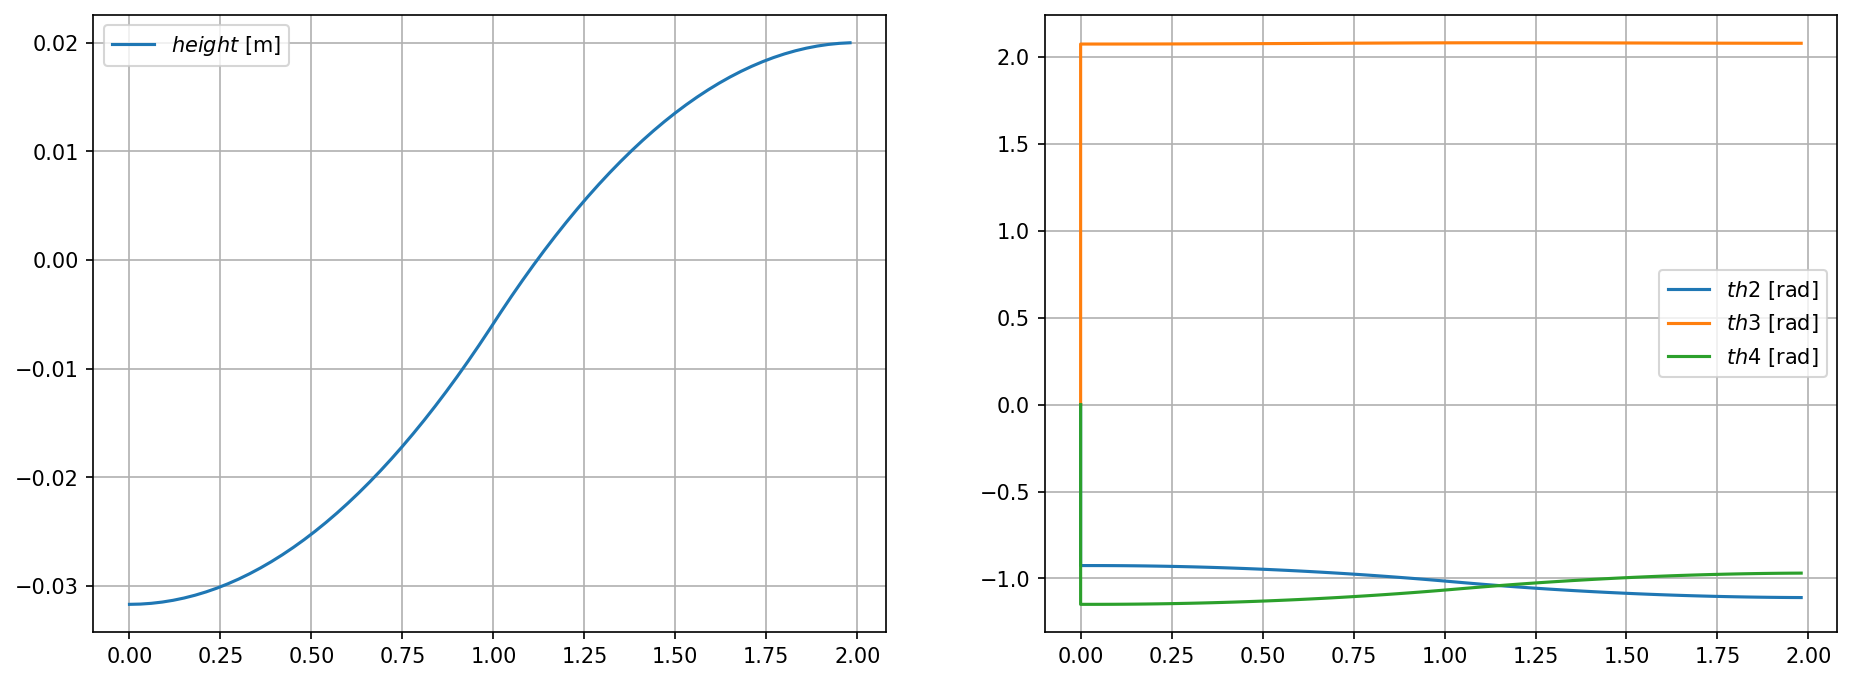

In [ ]:
time, traj = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(1,2,0.03)
height_path = utils.Path_Gen(x, 0.02, traj[:,0])

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(221);
pl.plot(time, height_path);
pl.legend([r'$height$ [m]'], loc='best')
pl.grid()

plt.grid(True, axis='y')

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(222);
pl.plot(time, q2list, time, q3list, time, q4list );
pl.legend([r'$th1$ [rad]', r'$th2$ [rad]', r'$th3$ [rad]', r'$th4$ [rad]'], loc='best')
pl.grid()

plt.grid(True, axis='y')

plt.show()

In [71]:
def get_torque_traj(q2list, q3list, q4list):
    time, traj = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(1,2,0.03)
    # thetalist = get_cur_deg()
    
    m1 = 2.486 + 0.3
    m2 = 1.416
    m3 = 1.739
    m4 = 16.09

    L1 = 0.171
    L2 = 0.28
    L3 = 0.280
    L4 = 0.346

    L1c = L1/2
    L2c = L2 - 0.045289
    L3c = L3 - 0.18878
    L4c = 0.17188

    traj_th1 = utils.Path_Gen(0, 0, traj[:,0])
    traj_th2 = utils.Path_Gen(q2list[0], q2list[-1], traj[:,0])
    traj_th3 = utils.Path_Gen(q3list[0], q3list[-1], traj[:,0])
    traj_th4 = utils.Path_Gen(q4list[0], q4list[-1], traj[:,0])

    traj_dth1 = utils.Path_Gen(0, 0, traj[:,1])
    traj_dth2 = utils.Path_Gen(q2list[0], q2list[-1], traj[:,1])
    traj_dth3 = utils.Path_Gen(q3list[0], q3list[-1], traj[:,1])
    traj_dth4 = utils.Path_Gen(q4list[0], q4list[-1], traj[:,1])

    traj_ddth1 = utils.Path_Gen(0, 0, traj[:,2])
    traj_ddth2 = utils.Path_Gen(q2list[0], q2list[-1], traj[:,2])
    traj_ddth3 = utils.Path_Gen(q3list[0], q3list[-1], traj[:,2])
    traj_ddth4 = utils.Path_Gen(q4list[0], q4list[-1], traj[:,2])

    eint = np.array([0.2, 0.2, 0.2, 0.2])
    g = np.array([0, 0, -9.8])
    theta_2 = 0
    theta_3 = 0
    
    M01 = np.array([[1, 0, 0,       0],
                    [0, 1, 0,       0],
                    [0, 0, 1,       0],
                    [0, 0, 0,       1]])
    M12 = np.array([[1, 0, 0,        0],
                    [0, 1, 0,       L1],
                    [0, 0,-1,        0],
                    [0, 0, 0,        1]])
    M23 = np.array([[ 1, 0, 0,      -L2*np.cos(theta_2)],
                    [ 0, 1, 0,      L2*np.sin(theta_2)],
                    [ 0, 0, -1,       0],
                    [ 0, 0, 0,       1]])
    M34 = np.array([[1, 0, 0,       L2*np.cos(theta_3)],
                    [0, 1, 0,       L2*np.sin(theta_3)],
                    [0, 0, -1,      0],
                    [0, 0, 0,       1]])
    M45 = np.array([[1, 0, 0,       0],
                    [0, 1, 0,      L4],
                    [0, 0, 1,       0],
                    [0, 0, 0,       1]])
    
    G1 = np.diag([0.010267, 0.010267, 0.00666, m1, m1, m1]) #X
    G2 = np.diag([0.010192583, 0.002390603, 0.009599672, m2, m2, m2])
    G3 = np.diag([0.008595913, 0.002944951, 0.007917693, m3, m3, m3])
    G4 = np.diag([0.0494433, 0.0494433, 0.004095, m4, m4, m4]) #X
    
    Glist = np.array([G1, G2, G3, G4])
    Mlist = np.array([M01, M12, M23, M34, M45])
    Slist = np.array([[0, 0, 1,      0, 0,     0],
                      [0, 0, -1,   -L1, 0,     0],
                      [0, 0, 1, L1 + L2 * np.sin(theta_2), -L2 * np.cos(theta_2), 0.425],
                      [0, 0, -1, -(L1 + L2 * np.sin(theta_2)+L3 * np.sin(theta_3)), L2 * np.cos(theta_2)-L3 * np.cos(theta_3), 0.425]]).T
    Kp = 1.3
    Ki = 1.2
    Kd = 1.1

    torquelist = np.array([0,0,0,0])

    for i in range(0, len(time)-1):

        thetalist = np.array([traj_th1[i], traj_th2[i], traj_th3[i], traj_th4[i]])
        dthetalist = np.array([traj_dth1[i], traj_dth2[i], traj_dth3[i], traj_dth4[i]])

        thetalistd = np.array([traj_th1[i+1], traj_th2[i+1], traj_th3[i+1], traj_th4[i+1]])
        dthetalistd = np.array([traj_dth1[i+1], traj_dth2[i+1], traj_dth3[i+1], traj_dth4[i+1]])
        ddthetalistd = np.array([traj_ddth1[i+1], traj_ddth2[i+1], traj_ddth3[i+1], traj_ddth4[i+1]])

        torque = mr.ComputedTorque(thetalist, dthetalist, eint, g, Mlist, Glist, Slist,thetalistd, dthetalistd, ddthetalistd, Kp, Ki, Kd)

        torquelist = np.vstack((torquelist,torque))  
    return torquelist

In [73]:
torquelist = get_torque_traj(q2list, q3list, q4list)

TypeError: loop of ufunc does not support argument 0 of type Zero which has no callable sqrt method